In [1]:
!git clone https://github.com/valleballe/deceptive-ai.git

Cloning into 'deceptive-ai'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 78 (delta 29), reused 58 (delta 17), pack-reused 0
Unpacking objects: 100% (78/78), 3.64 MiB | 1.83 MiB/s, done.


In [2]:
%cd /content/deceptive-ai/

/content/deceptive-ai


In [3]:
!pip install stargazer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from scipy import stats
from sklearn.metrics import roc_curve, roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

from scipy.stats import ttest_ind
import warnings
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import norm
import math
import seaborn as sns


warnings.filterwarnings('ignore')
%matplotlib inline

# color palette
palette1 = "#007BFF"
palette2 = "#3ABFC2"
palette3 = "#E1C081"
palette4 = "#E17A57"
palette5 = "#D92D3F"

red = 'crimson'
darkred = 'firebrick'
blue = 'lightskyblue'
darkblue = 'steelblue'
lightgrey = 'lightgrey'
darkgrey = 'darkgrey'

# load processed results
df = pd.read_csv("data/results/results_processed.csv")

# creating dummy variables aka binary features
df["trivia"] = df.stimulation=="trivia"
df["true_statement"] = (df.ground_truth==True).astype(int)
df["explanation"] = (df.condition=="flag+explanation").astype(int)
df["text_explanation"] = "No Explanation"
df.loc[df.explanation==1,"text_explanation"] = "GPT Explanation"
df["deceptive_feedback"] = (df.explanation_type=="Deceptive").astype(int)
df["valid_statement"] = (df.logical_validity=="VALID").astype(int)

# Calculate accuracy
df['initial_rating_accuracy'] = df.apply(lambda x: 1 - abs( x.true_statement - x['initial_rating']/5 ), axis=1)
df['second_rating_accuracy']  = df.apply(lambda x: 1 - abs( x.true_statement - x['second_rating'] /5 ), axis=1)
df['rating_delta_accuracy']  = df.second_rating_accuracy - df.initial_rating_accuracy
df['z_rating_delta_accuracy'] = (df.rating_delta_accuracy - df.rating_delta_accuracy.mean())/df.rating_delta_accuracy.std()

df["deceptive_feedback_x_explanation"] = df["deceptive_feedback"]*df["explanation"]
df["deceptive_feedback_x_true_statement"] = df["deceptive_feedback"]*df["true_statement"]
df["deceptive_feedback_x_ts_x_explanation"] = df["deceptive_feedback"]*df["explanation"]*df["true_statement"]
df["explanation_x_true_statement"] = df["explanation"]*df["true_statement"]
df["explanation_x_valid_statement"] = df["explanation"]*df["valid_statement"]
df["explanation_x_crt"] = df["explanation"]*df["CRT"]
df["explanation_x_trust"] = df["explanation"]*df["trust"]
df["explanation_x_knowledge"] = df["explanation"]*df["knowledge"]



df["rating_delta"] = df.second_rating - df.initial_rating
df['z_rating_delta'] = (df.rating_delta - df.rating_delta.mean())/df.rating_delta.std()


In [5]:
print([col for col in df.columns])

['PROLIFIC_PID', 'order', 'initial_rating', 'second_rating', 'knowledge', 'page_1_time', 'page_2_time', 'stimulus_ID', 'explanation_type', 'RecordedDate', 'Duration (in seconds)', 'Comments', 'trust', 'NFC', 'CRT', 'condition', 'stimulation', 'ground_truth', 'topic', 'logical_validity', 'trivia', 'true_statement', 'explanation', 'text_explanation', 'deceptive_feedback', 'valid_statement', 'initial_rating_accuracy', 'second_rating_accuracy', 'rating_delta_accuracy', 'z_rating_delta_accuracy', 'deceptive_feedback_x_explanation', 'deceptive_feedback_x_true_statement', 'deceptive_feedback_x_ts_x_explanation', 'explanation_x_true_statement', 'explanation_x_valid_statement', 'explanation_x_crt', 'explanation_x_trust', 'explanation_x_knowledge', 'rating_delta', 'z_rating_delta']


In [6]:
df.head()

,PROLIFIC_PID,order,initial_rating,second_rating,knowledge,page_1_time,page_2_time,stimulus_ID,explanation_type,RecordedDate,...,deceptive_feedback_x_explanation,deceptive_feedback_x_true_statement,deceptive_feedback_x_ts_x_explanation,explanation_x_true_statement,explanation_x_valid_statement,explanation_x_crt,explanation_x_trust,explanation_x_knowledge,rating_delta,z_rating_delta
0,6108e03508bd5499cf3c2a71,1,2.3,1.0,2.5,23.300,27.030,1022.0,Honest,2022-12-02 09:13:52,...,0,0,0,0,0,0.000000,0.000000,0.0,-1.3,-1.066436
1,5f78ce64cb5f144a98a4fa38,1,4.0,5.0,1.0,8.030,9.871,524.0,Honest,2022-12-02 09:15:10,...,0,0,0,0,0,0.000000,0.000000,0.0,1.0,0.860950
2,6046a861fd56950eb9e314ea,1,4.1,4.1,1.1,16.800,15.842,1038.0,Deceptive,2022-12-02 09:18:10,...,1,0,0,0,1,0.000000,3.500000,1.1,0.0,0.022956
3,5b66c8d4cda8590001dafb0c,1,2.0,4.5,2.0,12.168,14.103,1017.0,Deceptive,2022-12-02 09:18:53,...,1,0,0,0,0,0.666667,2.833333,2.0,2.5,2.117940
4,5f2c1cc33ea8e3068272d06c,1,1.0,1.0,2.1,5.601,14.100,1019.0,Deceptive,2022-12-02 09:20:48,...,1,0,0,0,0,0.333333,4.000000,2.1,0.0,0.022956


In [7]:
print(df.groupby("trivia").PROLIFIC_PID.count()/20)
print(df.groupby("true_statement").PROLIFIC_PID.count()/20)
print(df.groupby("explanation").PROLIFIC_PID.count()/20)
print(df['deceptive_feedback'].mean())
print(df['true_statement'].mean())


print(df.groupby(["trivia","explanation"])["PROLIFIC_PID"].nunique()) #"true_statement", "deceptive_feedback"

trivia
False    589.0
True     610.0
Name: PROLIFIC_PID, dtype: float64
true_statement
0    585.25
1    613.75
Name: PROLIFIC_PID, dtype: float64
explanation
0    588.0
1    611.0
Name: PROLIFIC_PID, dtype: float64
0.5037531276063386
0.5118849040867389
trivia  explanation
False   0              289
        1              300
True    0              299
        1              311
Name: PROLIFIC_PID, dtype: int64


# Results Belief

**Conclusion:** Both *z_rating_delta*  and *second_rating* show significant changes by GPT Explanation for False and True News Headlines with Deceptive Feedback, and True News headlines with Honest Feedback; but only true trivia with (regardless of deceptive and honest feedback). 

In [8]:
# Second rating x Explanation

x= []
for stimuli in [0,1]:
    for truth in [0,1]:
        for deception in [0,1]:
            i = df[(df.trivia==stimuli) & (df.true_statement==truth) & (df.deceptive_feedback==deception)]
            res = sm.OLS(i["second_rating"], 
                                  sm.add_constant(i[[
    #                                   'deceptive_feedback',
                                      'explanation',
    #                                   "deceptive_feedback_x_explanation",
                                  ]]), 
                                  M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': i['PROLIFIC_PID']})
            x.append(res)
stargazer = Stargazer([x[0],x[1],x[2],x[3],
                      x[4],x[5],x[6],x[7]])
stargazer.covariate_order([
                            'const',
                            'explanation',
                
                          ])

stargazer.custom_columns(['N – False (Honest)','N – False (Deceptive)',
                          'N – True (Honest)', 'N – True (Deceptive)',
                         'T – False (Honest)','T – False (Deceptive)',
                          'T – True (Honest)', 'T – True (Deceptive)'],
                         [1,1,1,1,1,1,1,1,])

stargazer.rename_covariates({
                            'const':'Constant',
                            'explanation':"GPT Explanation",
                            'deceptive_feedback': "Deceptive Feedback",
                            "deceptive_feedback_x_explanation": "Deceptive GPT Explanation",
                            })
stargazer.significant_digits(2)
stargazer.show_degrees_of_freedom(False)
stargazer.significance_levels([0.05, 0.01, 0.001])
stargazer.show_model_numbers(True)
HTML(stargazer.render_html())


In [13]:
# z_delta x explanation

x = []

for stimuli in [0,1]:
    for truth in [0,1]:
        for deception in [0,1]:
            i = df[(df.trivia==stimuli) & (df.true_statement==truth) & (df.deceptive_feedback==deception)]
            res = sm.OLS(i["z_rating_delta"], 
                                  sm.add_constant(i[[
    #                                   'deceptive_feedback',
                                      'explanation',
    #                                   "deceptive_feedback_x_explanation",
                                  ]]), 
                                  M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': i['PROLIFIC_PID']})
            x.append(res)
stargazer = Stargazer([x[0],x[1],x[2],x[3],
                      x[4],x[5],x[6],x[7]])
stargazer.covariate_order([
                            'const',
                            'explanation',
                
                          ])

stargazer.custom_columns(['N – False (Honest)','N – False (Deceptive)',
                          'N – True (Honest)', 'N – True (Deceptive)',
                         'T – False (Honest)','T – False (Deceptive)',
                          'T – True (Honest)', 'T – True (Deceptive)'],
                         [1,1,1,1,1,1,1,1,])

stargazer.rename_covariates({
                            'const':'Constant',
                            'explanation':"GPT Explanation",
                            'deceptive_feedback': "Deceptive Feedback",
                            "deceptive_feedback_x_explanation": "Deceptive GPT Explanation",
                            })
stargazer.significant_digits(2)
stargazer.show_degrees_of_freedom(False)
stargazer.significance_levels([0.05, 0.01, 0.001])
stargazer.show_model_numbers(True)

p_values_str = []
for res in x:
    p_value_str = ', '.join([f"{var}: {p:.4f}" for var, p in zip(res.params.index, res.pvalues)])
    p_values_str.append(p_value_str)

HTML(stargazer.render_html())

In [12]:
p_values_str

['const: 0.0000, explanation: 0.1689',
 'const: 0.0000, explanation: 0.0043',
 'const: 0.0000, explanation: 0.0014',
 'const: 0.0000, explanation: 0.0000',
 'const: 0.0000, explanation: 0.1840',
 'const: 0.0000, explanation: 0.4983',
 'const: 0.0000, explanation: 0.0034',
 'const: 0.0000, explanation: 0.0023']

# Personal Factors

In [15]:
# CRT

x= []
for stimuli in [0,1]:
    for truth in [0,1]:
        for deception in [0,1]:
            i = df[(df.trivia==stimuli) & (df.true_statement==truth) & (df.deceptive_feedback==deception)]
            res = sm.OLS(i["z_rating_delta"], 
                                  sm.add_constant(i[[
                                      "CRT",
                                  ]]), 
                                  M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': i['PROLIFIC_PID']})
            x.append(res)
stargazer = Stargazer([x[0],x[1],x[2],x[3],
                      x[4],x[5],x[6],x[7]])
stargazer.covariate_order([
                            'const',
                            "CRT",
                          ])
stargazer.custom_columns(['N – False (Honest)','N – False (Deceptive)',
                          'N – True (Honest)', 'N – True (Deceptive)',
                         'T – False (Honest)','T – False (Deceptive)',
                          'T – True (Honest)', 'T – True (Deceptive)'],
                         [1,1,1,1,1,1,1,1,])
stargazer.rename_covariates({
                            'const':'Constant',
                            'CRT': "CRT",
                            })
stargazer.significant_digits(2)
stargazer.show_degrees_of_freedom(False)
stargazer.significance_levels([0.05, 0.01, 0.001])
stargazer.show_model_numbers(True)
HTML(stargazer.render_html())

In [16]:
# Logical Validity

x= []
for stimuli in [0,1]:
    for truth in [0,1]:
        for deception in [0,1]:
            i = df[(df.trivia==stimuli) & (df.true_statement==truth) & (df.deceptive_feedback==deception)]
            res = sm.OLS(i["z_rating_delta"], 
                                  sm.add_constant(i[[
                                      "valid_statement",
                                  ]]), 
                                  M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': i['PROLIFIC_PID']})
            x.append(res)
stargazer = Stargazer([x[0],x[1],x[2],x[3],
                      x[4],x[5],x[6],x[7]])
stargazer.covariate_order([
                            'const',
                            "valid_statement",
                          ])
stargazer.custom_columns(['N – False (Honest)','N – False (Deceptive)',
                          'N – True (Honest)', 'N – True (Deceptive)',
                         'T – False (Honest)','T – False (Deceptive)',
                          'T – True (Honest)', 'T – True (Deceptive)'],
                         [1,1,1,1,1,1,1,1,])
stargazer.rename_covariates({
                            'const':'Constant',
                            "valid_statement": "Logical Validity",
                            })
stargazer.significant_digits(2)
stargazer.show_degrees_of_freedom(False)
stargazer.significance_levels([0.05, 0.01, 0.001])
stargazer.show_model_numbers(True)
HTML(stargazer.render_html())

In [18]:
# TRUST

x= []
for stimuli in [0,1]:
    for truth in [0,1]:
        for deception in [0,1]:
            i = df[(df.trivia==stimuli) & (df.true_statement==truth) & (df.deceptive_feedback==deception)]
            res = sm.OLS(i["z_rating_delta"], 
                                  sm.add_constant(i[[
                                      "trust",
                                  ]]), 
                                  M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': i['PROLIFIC_PID']})
            x.append(res)
stargazer = Stargazer([x[0],x[1],x[2],x[3],
                      x[4],x[5],x[6],x[7]])
stargazer.covariate_order([
                            'const',
                            "trust",
                          ])
stargazer.custom_columns(['N – False (Honest)','N – False (Deceptive)',
                          'N – True (Honest)', 'N – True (Deceptive)',
                         'T – False (Honest)','T – False (Deceptive)',
                          'T – True (Honest)', 'T – True (Deceptive)'],
                         [1,1,1,1,1,1,1,1,])
stargazer.rename_covariates({
                            'const':'Constant',
                            "trust":"Trust",
                            })
stargazer.significant_digits(2)
stargazer.show_degrees_of_freedom(False)
stargazer.significance_levels([0.05, 0.01, 0.001])
stargazer.show_model_numbers(True)
HTML(stargazer.render_html())

In [23]:
# TRUST

x= []
for stimuli in [0,1]:
    for truth in [0,1]:
        for deception in [0,1]:
            i = df[(df.trivia==stimuli) & (df.true_statement==truth) & (df.deceptive_feedback==deception)]
            res = sm.OLS(i["z_rating_delta"], 
                                  sm.add_constant(i[[
                                      "knowledge",
                                  ]]), 
                                  M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': i['PROLIFIC_PID']})
            x.append(res)
stargazer = Stargazer([x[0],x[1],x[2],x[3],
                      x[4],x[5],x[6],x[7]])
stargazer.covariate_order([
                            'const',
                            "knowledge",
                          ])
stargazer.custom_columns(['N – False (Honest)','N – False (Deceptive)',
                          'N – True (Honest)', 'N – True (Deceptive)',
                         'T – False (Honest)','T – False (Deceptive)',
                          'T – True (Honest)', 'T – True (Deceptive)'],
                         [1,1,1,1,1,1,1,1,])
stargazer.rename_covariates({
                            'const':'Constant',
                            "knowledge":"Knowledge",
                            })
stargazer.significant_digits(2)
stargazer.show_degrees_of_freedom(False)
stargazer.significance_levels([0.05, 0.01, 0.001])
stargazer.show_model_numbers(True)
HTML(stargazer.render_html())

In [19]:
# Explanation * CRT

x= []
for stimuli in [0,1]:
    for truth in [0,1]:
        for deception in [0,1]:
            i = df[(df.trivia==stimuli) & (df.true_statement==truth) & (df.deceptive_feedback==deception)]
            res = sm.OLS(i["z_rating_delta"], 
                                  sm.add_constant(i[[
                                      "explanation_x_crt",
                                  ]]), 
                                  M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': i['PROLIFIC_PID']})
            x.append(res)
stargazer = Stargazer([x[0],x[1],x[2],x[3],
                      x[4],x[5],x[6],x[7]])
stargazer.covariate_order([
                            'const',
                            "explanation_x_crt",
                
                          ])
stargazer.custom_columns(['N – False (Honest)','N – False (Deceptive)',
                          'N – True (Honest)', 'N – True (Deceptive)',
                         'T – False (Honest)','T – False (Deceptive)',
                          'T – True (Honest)', 'T – True (Deceptive)'],
                         [1,1,1,1,1,1,1,1,])
stargazer.rename_covariates({
                            'const':'Constant',
                            "explanation_x_crt": "Explanation * CRT",
                            })
stargazer.significant_digits(2)
stargazer.show_degrees_of_freedom(False)
stargazer.significance_levels([0.05, 0.01, 0.001])
stargazer.show_model_numbers(True)
HTML(stargazer.render_html())

In [20]:
# Explanation * Valid Statement

x= []
for stimuli in [0,1]:
    for truth in [0,1]:
        for deception in [0,1]:
            i = df[(df.trivia==stimuli) & (df.true_statement==truth) & (df.deceptive_feedback==deception)]
            res = sm.OLS(i["z_rating_delta"], 
                                  sm.add_constant(i[[
                                      "explanation_x_valid_statement",
                                  ]]), 
                                  M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': i['PROLIFIC_PID']})
            x.append(res)
stargazer = Stargazer([x[0],x[1],x[2],x[3],
                      x[4],x[5],x[6],x[7]])
stargazer.covariate_order([
                            'const',
                            "explanation_x_valid_statement",
                          ])
stargazer.custom_columns(['N – False (Honest)','N – False (Deceptive)',
                          'N – True (Honest)', 'N – True (Deceptive)',
                         'T – False (Honest)','T – False (Deceptive)',
                          'T – True (Honest)', 'T – True (Deceptive)'],
                         [1,1,1,1,1,1,1,1,])
stargazer.rename_covariates({
                            'const':'Constant',
                            "explanation_x_valid_statement":"Explanation * Validity",
                            })
stargazer.significant_digits(2)
stargazer.show_degrees_of_freedom(False)
stargazer.significance_levels([0.05, 0.01, 0.001])
stargazer.show_model_numbers(True)
HTML(stargazer.render_html())

In [21]:
# Explanation * Knowledge

x= []
for stimuli in [0,1]:
    for truth in [0,1]:
        for deception in [0,1]:
            i = df[(df.trivia==stimuli) & (df.true_statement==truth) & (df.deceptive_feedback==deception)]
            res = sm.OLS(i["z_rating_delta"], 
                                  sm.add_constant(i[[
                                      'explanation_x_knowledge',
                                  ]]), 
                                  M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': i['PROLIFIC_PID']})
            x.append(res)
stargazer = Stargazer([x[0],x[1],x[2],x[3],
                      x[4],x[5],x[6],x[7]])
stargazer.covariate_order([
                            'const',
                            'explanation_x_knowledge'
                          ])
stargazer.custom_columns(['N – False (Honest)','N – False (Deceptive)',
                          'N – True (Honest)', 'N – True (Deceptive)',
                         'T – False (Honest)','T – False (Deceptive)',
                          'T – True (Honest)', 'T – True (Deceptive)'],
                         [1,1,1,1,1,1,1,1,])
stargazer.rename_covariates({
                            'const':'Constant',
                            'explanation_x_knowledge': "Explanation * Knowledge",
                            })
stargazer.significant_digits(2)
stargazer.show_degrees_of_freedom(False)
stargazer.significance_levels([0.05, 0.01, 0.001])
stargazer.show_model_numbers(True)
HTML(stargazer.render_html())

In [22]:
# Explanation * Trust

x= []
for stimuli in [0,1]:
    for truth in [0,1]:
        for deception in [0,1]:
            i = df[(df.trivia==stimuli) & (df.true_statement==truth) & (df.deceptive_feedback==deception)]
            res = sm.OLS(i["z_rating_delta"], 
                                  sm.add_constant(i[[
                                      'explanation_x_trust',
                                  ]]), 
                                  M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': i['PROLIFIC_PID']})
            x.append(res)
stargazer = Stargazer([x[0],x[1],x[2],x[3],
                      x[4],x[5],x[6],x[7]])
stargazer.covariate_order([
                            'const',
                            'explanation_x_trust',
                          ])
stargazer.custom_columns(['N – False (Honest)','N – False (Deceptive)',
                          'N – True (Honest)', 'N – True (Deceptive)',
                         'T – False (Honest)','T – False (Deceptive)',
                          'T – True (Honest)', 'T – True (Deceptive)'],
                         [1,1,1,1,1,1,1,1,])
stargazer.rename_covariates({
                            'const':'Constant',
                            'explanation_x_trust': "Explanation * Trust"
                            })
stargazer.significant_digits(2)
stargazer.show_degrees_of_freedom(False)
stargazer.significance_levels([0.05, 0.01, 0.001])
stargazer.show_model_numbers(True)
HTML(stargazer.render_html())

# Plotting

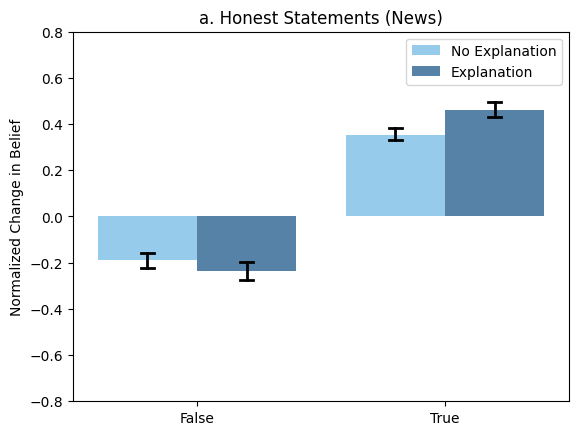

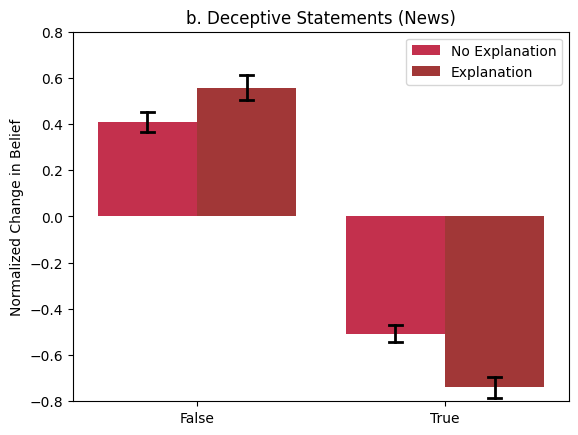

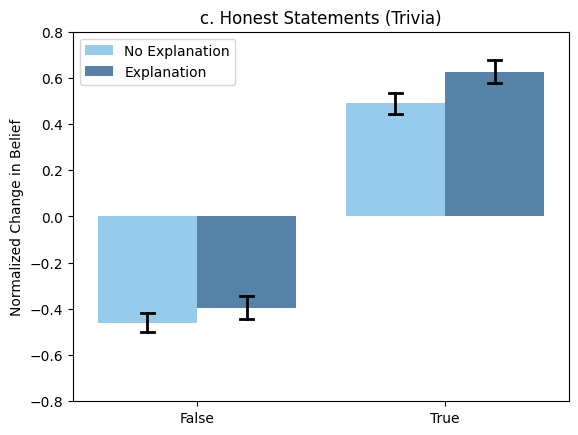

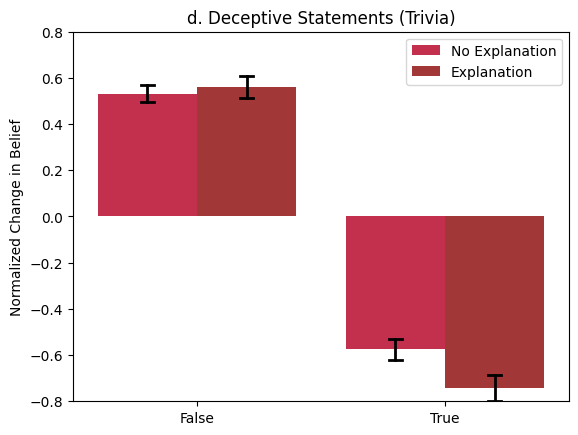

In [24]:
def plotter(data,name, hue, palette):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)

    data['text_explanation'] = data['text_explanation'].map({'No Explanation':'No Explanation', 'GPT Explanation' : 'Explanation'})
    ax = sns.barplot(x="true_statement", y="z_rating_delta",hue=hue,                    
                     hue_order=["No Explanation","Explanation"],
                     data=data, 
                     alpha=.99,
                     errcolor="black", errwidth=2, capsize=.05,
#                      order=[ 'Atopic Dermatitis', 'CTCL', 'Dermatomyositis','Lichen Planus', 'Lyme',
#                             'Pityriasis Rosea', 
#            'Pityriasis Rubra Pilaris',  
#             'Secondary Syphilis',"Additional",],
                     palette=palette)
    ax.set_ylabel("Normalized Change in Belief")
    ax.set_xlabel("")
    ax.set_xticklabels(['False', 'True'])
    ax.legend()
    ax.set_ylim(-.8,.8)
    ax.set_title("{}".format(name))
    fig.savefig("f1_{}.png".format(name),dpi=600, bbox_inches="tight")
    plt.show()


blue_palette = sns.set_palette(sns.color_palette([blue, darkblue]))
plotter(df[(df.trivia==0) & (df.deceptive_feedback==0)],"a. Honest Statements (News)","text_explanation", blue_palette)
red_palette = sns.set_palette(sns.color_palette([red, darkred]))
plotter(df[(df.trivia==0) & (df.deceptive_feedback==1)],"b. Deceptive Statements (News)","text_explanation", red_palette)
blue_palette = sns.set_palette(sns.color_palette([blue, darkblue]))
plotter(df[(df.trivia==1) & (df.deceptive_feedback==0)],"c. Honest Statements (Trivia)","text_explanation", blue_palette)
red_palette = sns.set_palette(sns.color_palette([red, darkred]))
plotter(df[(df.trivia==1) & (df.deceptive_feedback==1)],"d. Deceptive Statements (Trivia)","text_explanation", red_palette)

Accuracy 

In [82]:
# Create a new DataFrame with the columns you want to keep
new_df = df.copy().drop(columns=['second_rating'])

# Rename the 'initial_rating' column to 'second_rating'
new_df.rename(columns={'initial_rating': 'second_rating'}, inplace=True)

# Add a new column 'explanation_type' with the value 'Control'
new_df['text_explanation'] = 'Control'

# Concatenate the original DataFrame with the new DataFrame
result_df = pd.concat([df, new_df], ignore_index=True)

# Reset the index of the resulting DataFrame
result_df.reset_index(drop=True, inplace=True)

# Calculate accuracy
result_df['second_rating_accuracy']  = result_df.apply(lambda x: 1 - abs( x.true_statement - x['second_rating'] /5 ), axis=1)

# Check column
result_df.text_explanation.unique()

array(['No Explanation', 'GPT Explanation', 'Control'], dtype=object)

In [86]:
print([col for col in result_df.columns])

['PROLIFIC_PID', 'order', 'initial_rating', 'second_rating', 'knowledge', 'page_1_time', 'page_2_time', 'stimulus_ID', 'explanation_type', 'RecordedDate', 'Duration (in seconds)', 'Comments', 'trust', 'NFC', 'CRT', 'condition', 'stimulation', 'ground_truth', 'topic', 'logical_validity', 'trivia', 'true_statement', 'explanation', 'text_explanation', 'deceptive_feedback', 'valid_statement', 'initial_rating_accuracy', 'second_rating_accuracy', 'rating_delta_accuracy', 'z_rating_delta_accuracy', 'deceptive_feedback_x_explanation', 'deceptive_feedback_x_true_statement', 'deceptive_feedback_x_ts_x_explanation', 'explanation_x_true_statement', 'explanation_x_valid_statement', 'explanation_x_crt', 'explanation_x_trust', 'explanation_x_knowledge', 'rating_delta', 'z_rating_delta']


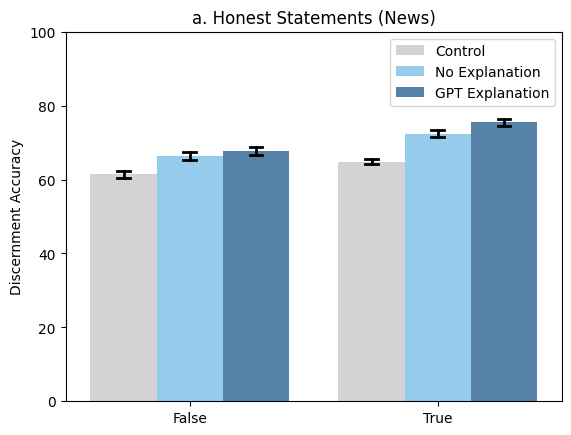

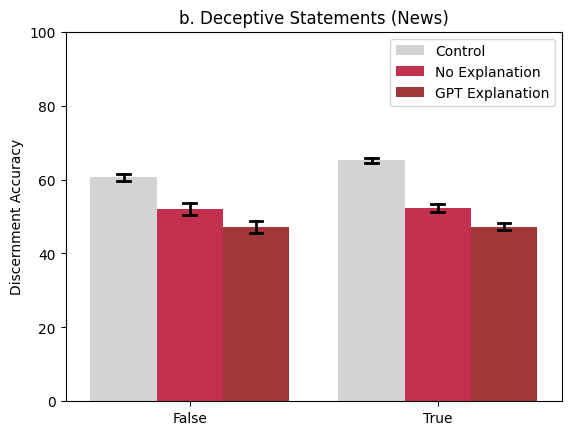

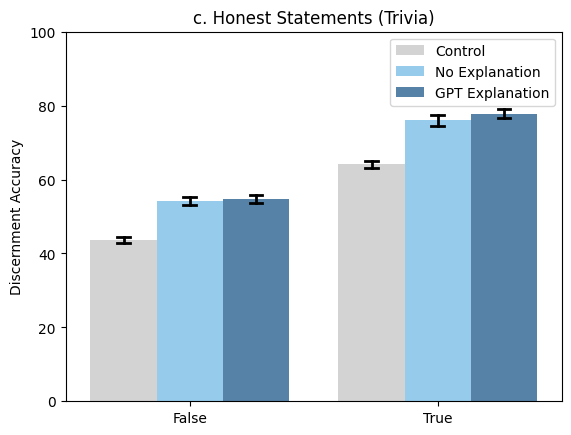

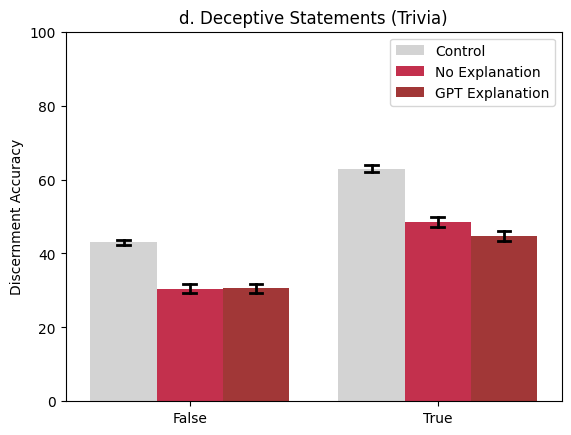

In [101]:
def plotter(data, name, hue, palette):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)

    #data['text_explanation'] = data['text_explanation'].map({'No Explanation':'No Explanation', 'GPT Explanation' : 'Explanation'})
    data.second_rating_accuracy = data.second_rating_accuracy * 100
    ax = sns.barplot(x="true_statement", y="second_rating_accuracy",hue=hue,                    
                     hue_order=["Control","No Explanation","GPT Explanation"],
                     data=data, 
                     alpha=.99,
                     errcolor="black", errwidth=2, capsize=.05,
                     palette=palette)
    ax.set_ylabel("Discernment Accuracy")
    ax.set_xlabel("")
    ax.set_xticklabels(['False', 'True'])
    ax.legend()
    ax.set_ylim(0,100)
    #ax.set_ylim(-.8,.8)
    ax.set_title("{}".format(name))
    fig.savefig("f1_acc_{}.png".format(name),dpi=600, bbox_inches="tight")
    plt.show()


blue_palette = sns.set_palette(sns.color_palette([lightgrey, blue, darkblue]))
plotter(result_df[(result_df.trivia==0) & (result_df.deceptive_feedback==0)],"a. Honest Statements (News)","text_explanation", blue_palette)
red_palette = sns.set_palette(sns.color_palette([lightgrey, red, darkred]))
plotter(result_df[(result_df.trivia==0) & (result_df.deceptive_feedback==1)],"b. Deceptive Statements (News)","text_explanation", red_palette)
blue_palette = sns.set_palette(sns.color_palette([lightgrey, blue, darkblue]))
plotter(result_df[(result_df.trivia==1) & (result_df.deceptive_feedback==0)],"c. Honest Statements (Trivia)","text_explanation", blue_palette)
red_palette = sns.set_palette(sns.color_palette([lightgrey, red, darkred]))
plotter(result_df[(result_df.trivia==1) & (result_df.deceptive_feedback==1)],"d. Deceptive Statements (Trivia)","text_explanation", red_palette)

Personal factors

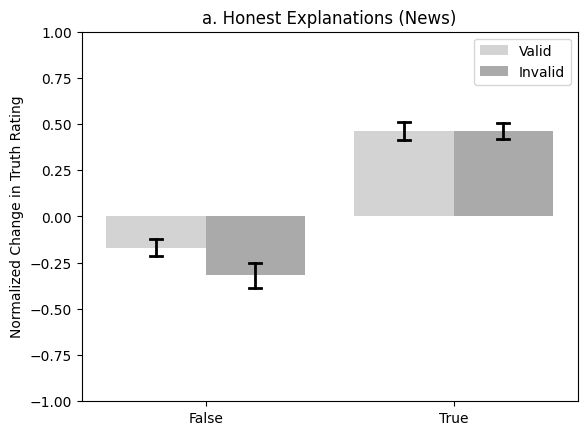

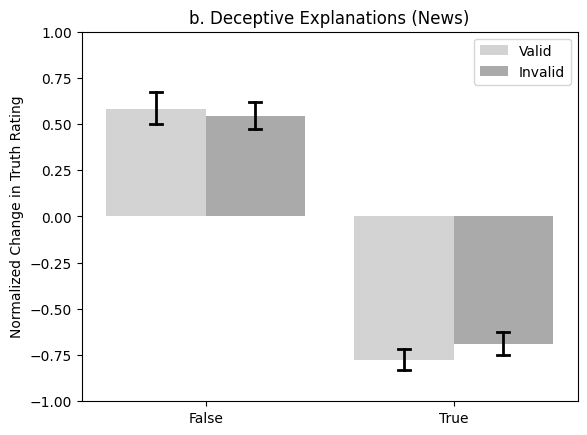

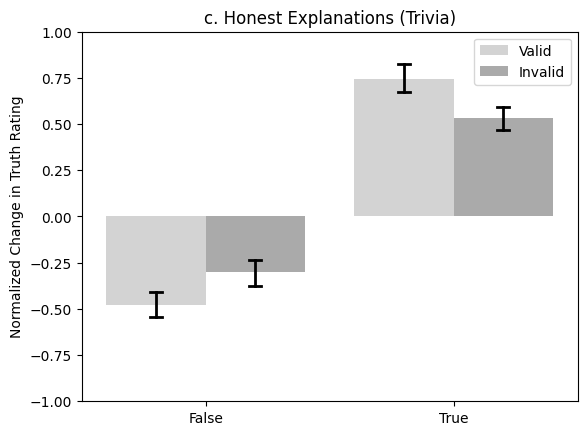

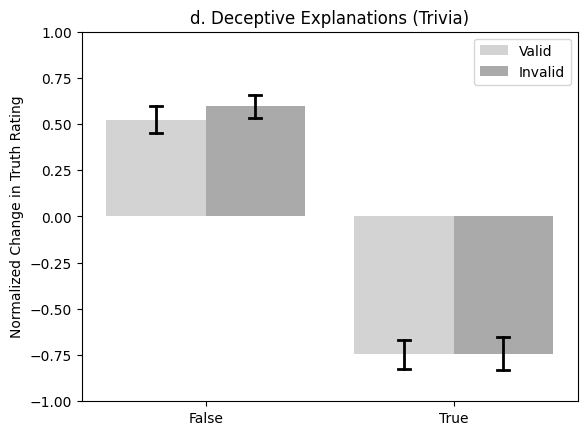

In [47]:
def plotter(data,name, x, palette):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)

    data = data[data['text_explanation'] == 'GPT Explanation']
    #data['text_explanation'] = data['text_explanation'].map({'No Explanation':'No Explanation', 'GPT Explanation' : 'Explanation'})
    data['Logical Validity'] = data['valid_statement'].map({0:'Invalid', 1 : 'Valid'})
    #data['Validity * Explanation'] = data.apply(lambda x: x['text_explanation']+" & "+x['valid_statement'], axis=1)#.map({0:'Invalid', 1 : 'Valid'})

    ax = sns.barplot(x="true_statement", y="z_rating_delta",hue='Logical Validity',
                     order=[0, 1],                    
                     hue_order=['Valid', 'Invalid'],
                     data=data, 
                     alpha=.99,
                     errcolor="black", errwidth=2, capsize=.05,
                     palette=palette)
    
    ax.set_ylabel("Normalized Change in Truth Rating")
    ax.set_xlabel("")
    ax.set_xticklabels(['False', 'True'])
    ax.legend()
    ax.set_ylim(-1,1)
    ax.set_title("{}".format(name))
    fig.savefig("f1_{}.png".format(name),dpi=600, bbox_inches="tight")
    plt.show()


blue_palette = sns.set_palette(sns.color_palette([lightgrey, darkgrey]))
plotter(df[(df.trivia==0) & (df.deceptive_feedback==0)],"a. Honest Explanations (News)","text_explanation", blue_palette)
red_palette = sns.set_palette(sns.color_palette([lightgrey, darkgrey]))
plotter(df[(df.trivia==0) & (df.deceptive_feedback==1)],"b. Deceptive Explanations (News)","text_explanation", red_palette)
blue_palette = sns.set_palette(sns.color_palette([lightgrey, darkgrey]))
plotter(df[(df.trivia==1) & (df.deceptive_feedback==0)],"c. Honest Explanations (Trivia)","text_explanation", blue_palette)
red_palette = sns.set_palette(sns.color_palette([lightgrey, darkgrey]))
plotter(df[(df.trivia==1) & (df.deceptive_feedback==1)],"d. Deceptive Explanations (Trivia)","text_explanation", red_palette)

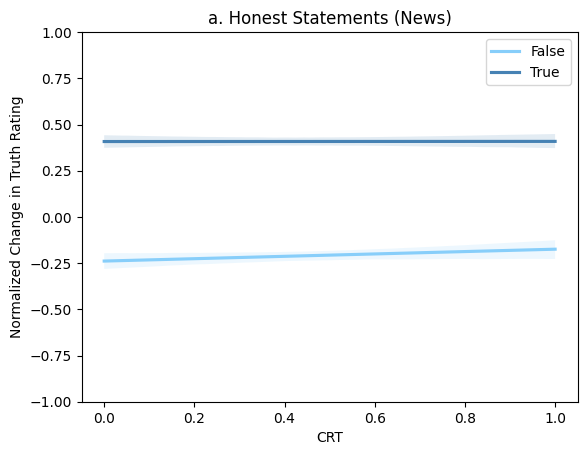

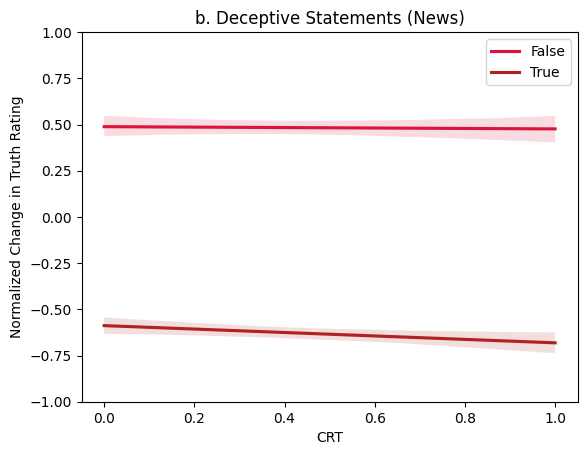

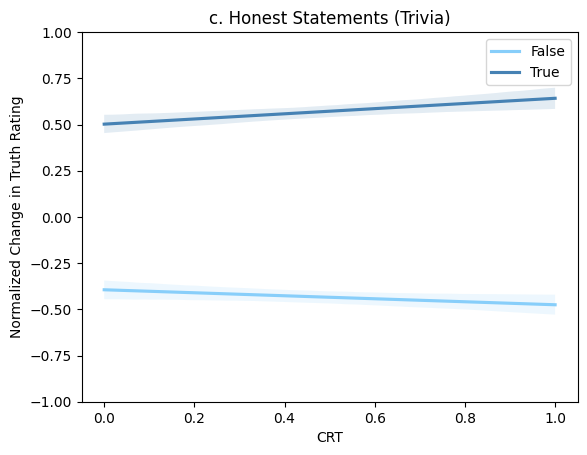

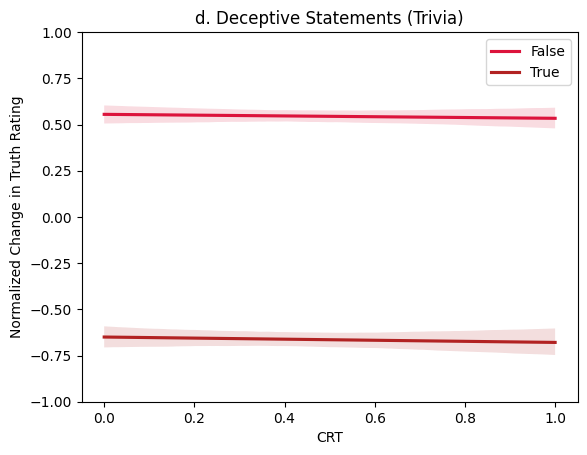

In [107]:
def plotter(data,name, x, palette):
    fig = plt.figure()
    #ax = fig.add_subplot(1,1,1)

    data['text_explanation'] = data['text_explanation'].map({'No Explanation':'No Explanation', 'GPT Explanation' : 'Explanation'})
    data = data.sort_values(by='true_statement')
    data['true_statement'] = data['true_statement'].map({0:'False', 1:'True'})

    ax = sns.regplot(x="CRT", y="z_rating_delta",               
                     data=data[data.true_statement == "False"],
                     scatter=False, label="False")
    
    ax = sns.regplot(x="CRT", y="z_rating_delta",               
                     data=data[data.true_statement == "True"],
                     scatter=False, label="True")
    
    ax.set_ylabel("Normalized Change in Truth Rating")
    ax.set_xlabel("CRT")
    #ax.set_xticklabels(['False', 'True'])
    ax.legend()
    ax.set_ylim(-1,1)
    ax.set_title("{}".format(name))
    fig.savefig("f1_crt_{}.png".format(name),dpi=600, bbox_inches="tight")
    plt.show()


blue_palette = sns.set_palette(sns.color_palette([blue, darkblue]))
plotter(df[(df.trivia==0) & (df.deceptive_feedback==0)],"a. Honest Statements (News)","text_explanation", blue_palette)
red_palette = sns.set_palette(sns.color_palette([red, darkred]))
plotter(df[(df.trivia==0) & (df.deceptive_feedback==1)],"b. Deceptive Statements (News)","text_explanation", red_palette)
blue_palette = sns.set_palette(sns.color_palette([blue, darkblue]))
plotter(df[(df.trivia==1) & (df.deceptive_feedback==0)],"c. Honest Statements (Trivia)","text_explanation", blue_palette)
red_palette = sns.set_palette(sns.color_palette([red, darkred]))
plotter(df[(df.trivia==1) & (df.deceptive_feedback==1)],"d. Deceptive Statements (Trivia)","text_explanation", red_palette)

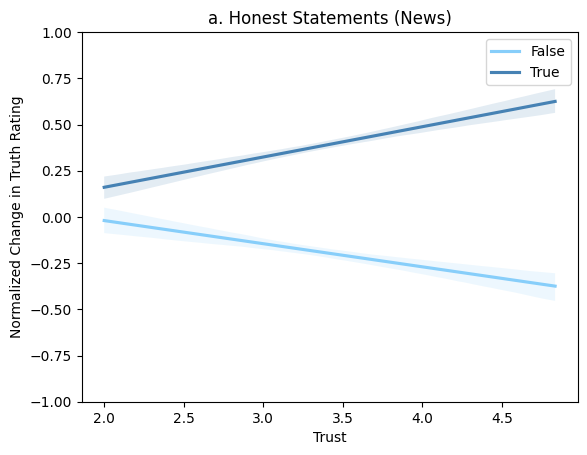

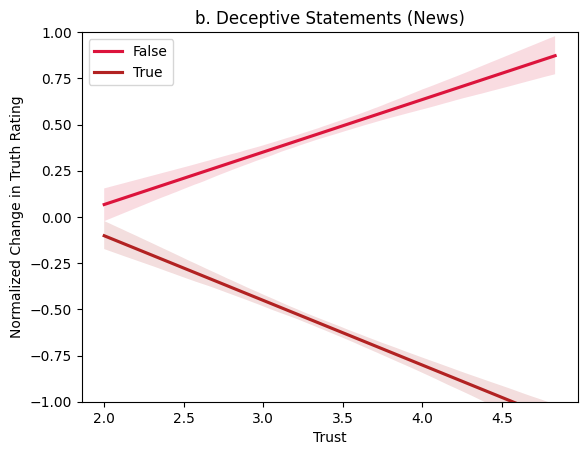

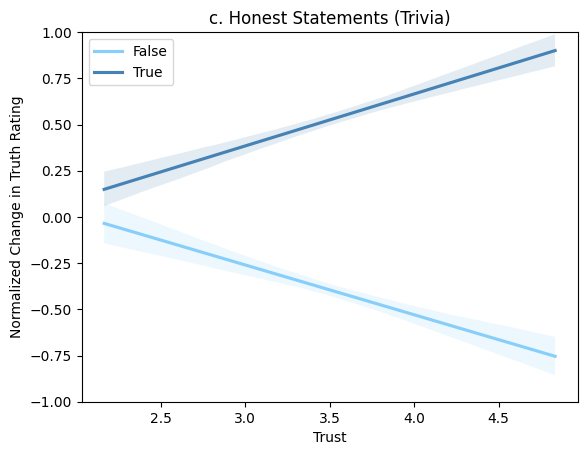

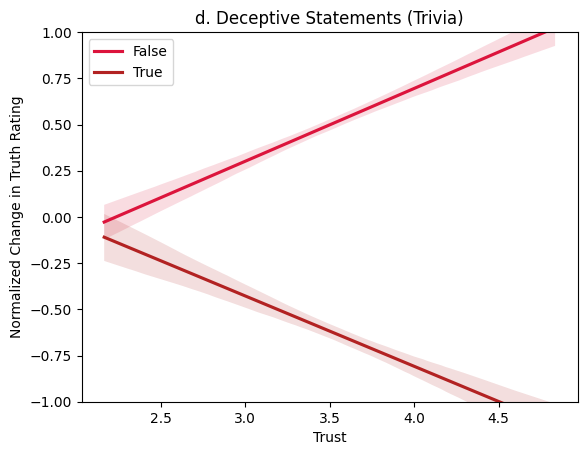

In [103]:
def plotter(data,name, x, palette):
    fig = plt.figure()
    #ax = fig.add_subplot(1,1,1)

    data['text_explanation'] = data['text_explanation'].map({'No Explanation':'No Explanation', 'GPT Explanation' : 'Explanation'})
    data = data.sort_values(by='true_statement')
    data['true_statement'] = data['true_statement'].map({0:'False', 1:'True'})

    ax = sns.regplot(x="trust", y="z_rating_delta",               
                     data=data[data.true_statement == "False"],
                     scatter=False, label="False")
    
    ax = sns.regplot(x="trust", y="z_rating_delta",               
                     data=data[data.true_statement == "True"],
                     scatter=False, label="True")
    
    ax.set_ylabel("Normalized Change in Truth Rating")
    ax.set_xlabel("Trust")
    #ax.set_xticklabels(['False', 'True'])
    ax.legend()
    ax.set_ylim(-1,1)
    ax.set_title("{}".format(name))
    fig.savefig("f1_trust_{}.png".format(name),dpi=600, bbox_inches="tight")
    plt.show()


blue_palette = sns.set_palette(sns.color_palette([blue, darkblue]))
plotter(df[(df.trivia==0) & (df.deceptive_feedback==0)],"a. Honest Statements (News)","text_explanation", blue_palette)
red_palette = sns.set_palette(sns.color_palette([red, darkred]))
plotter(df[(df.trivia==0) & (df.deceptive_feedback==1)],"b. Deceptive Statements (News)","text_explanation", red_palette)
blue_palette = sns.set_palette(sns.color_palette([blue, darkblue]))
plotter(df[(df.trivia==1) & (df.deceptive_feedback==0)],"c. Honest Statements (Trivia)","text_explanation", blue_palette)
red_palette = sns.set_palette(sns.color_palette([red, darkred]))
plotter(df[(df.trivia==1) & (df.deceptive_feedback==1)],"d. Deceptive Statements (Trivia)","text_explanation", red_palette)

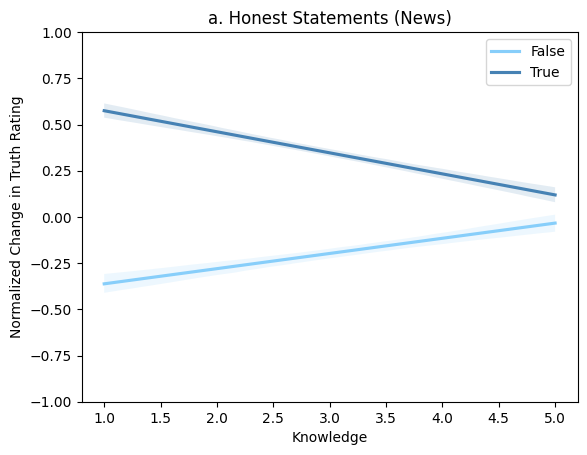

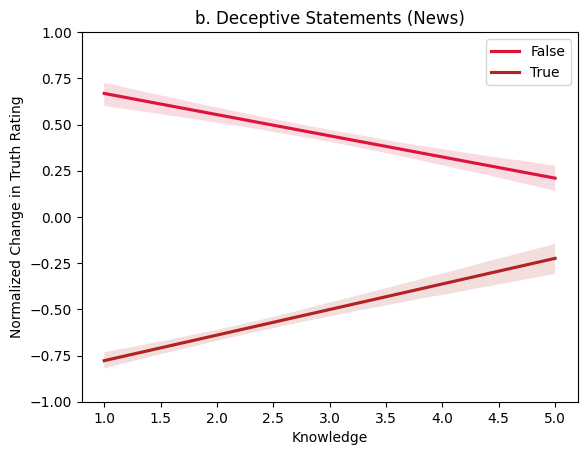

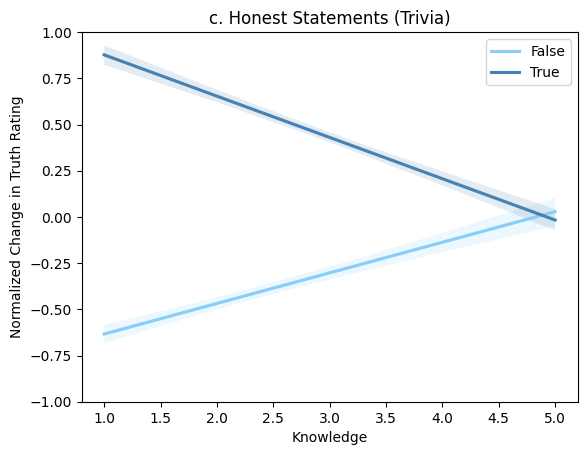

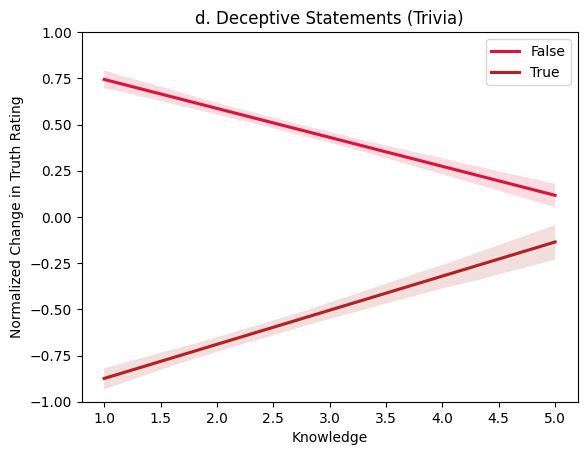

In [105]:
def plotter(data,name, x, palette):
    fig = plt.figure()
    #ax = fig.add_subplot(1,1,1)

    data['text_explanation'] = data['text_explanation'].map({'No Explanation':'No Explanation', 'GPT Explanation' : 'Explanation'})
    data = data.sort_values(by='true_statement')
    data['true_statement'] = data['true_statement'].map({0:'False', 1:'True'})

    ax = sns.regplot(x="knowledge", y="z_rating_delta",               
                     data=data[data.true_statement == "False"],
                     scatter=False, label="False")
    
    ax = sns.regplot(x="knowledge", y="z_rating_delta",               
                     data=data[data.true_statement == "True"],
                     scatter=False, label="True")
    
    ax.set_ylabel("Normalized Change in Truth Rating")
    ax.set_xlabel("Knowledge")
    #ax.set_xticklabels(['False', 'True'])
    ax.legend()
    ax.set_ylim(-1,1)
    ax.set_title("{}".format(name))
    fig.savefig("f1_knowledge_{}.png".format(name),dpi=600, bbox_inches="tight")
    plt.show()


blue_palette = sns.set_palette(sns.color_palette([blue, darkblue]))
plotter(df[(df.trivia==0) & (df.deceptive_feedback==0)],"a. Honest Statements (News)","text_explanation", blue_palette)
red_palette = sns.set_palette(sns.color_palette([red, darkred]))
plotter(df[(df.trivia==0) & (df.deceptive_feedback==1)],"b. Deceptive Statements (News)","text_explanation", red_palette)
blue_palette = sns.set_palette(sns.color_palette([blue, darkblue]))
plotter(df[(df.trivia==1) & (df.deceptive_feedback==0)],"c. Honest Statements (Trivia)","text_explanation", blue_palette)
red_palette = sns.set_palette(sns.color_palette([red, darkred]))
plotter(df[(df.trivia==1) & (df.deceptive_feedback==1)],"d. Deceptive Statements (Trivia)","text_explanation", red_palette)

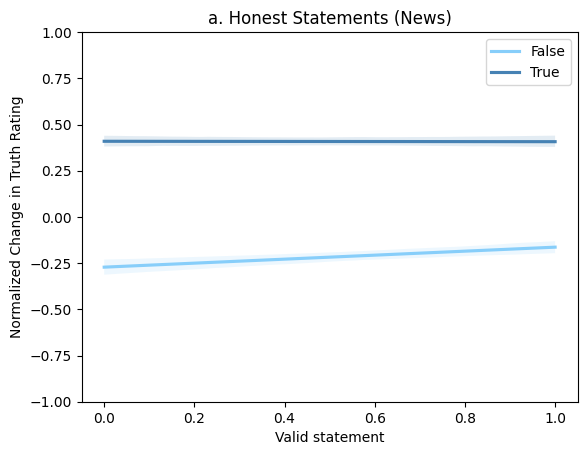

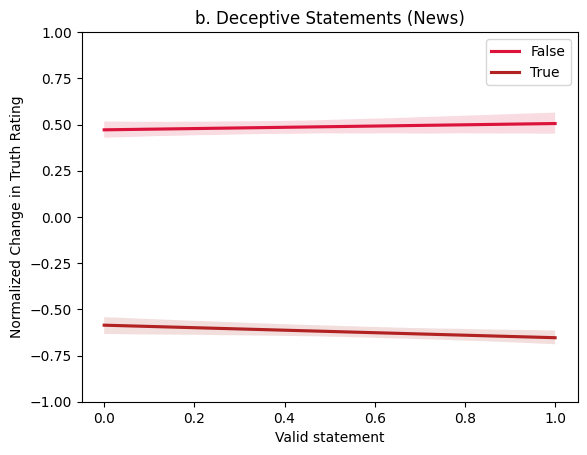

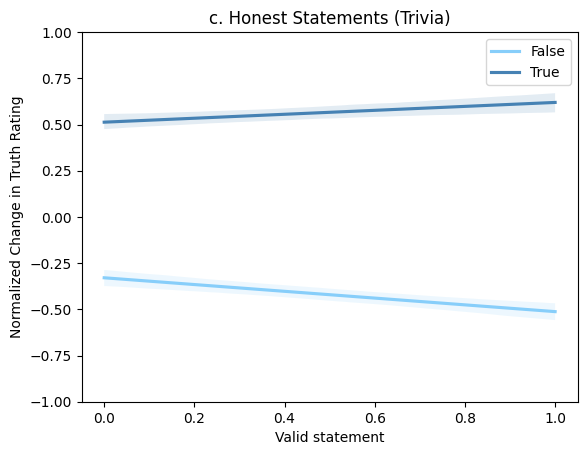

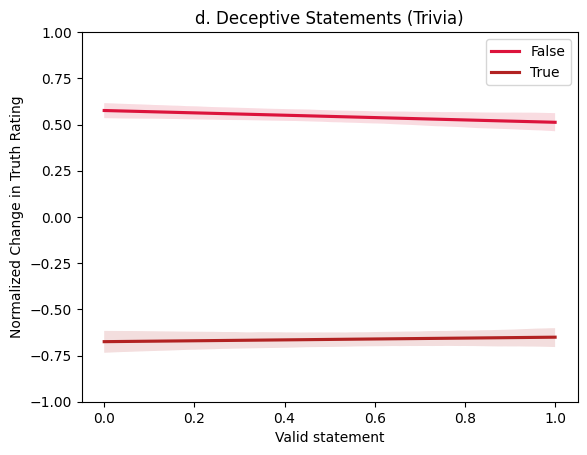

In [106]:
def plotter(data,name, x, palette):
    fig = plt.figure()
    #ax = fig.add_subplot(1,1,1)

    data['text_explanation'] = data['text_explanation'].map({'No Explanation':'No Explanation', 'GPT Explanation' : 'Explanation'})
    data = data.sort_values(by='true_statement')
    data['true_statement'] = data['true_statement'].map({0:'False', 1:'True'})

    ax = sns.regplot(x="valid_statement", y="z_rating_delta",               
                     data=data[data.true_statement == "False"],
                     scatter=False, label="False")
    
    ax = sns.regplot(x="valid_statement", y="z_rating_delta",               
                     data=data[data.true_statement == "True"],
                     scatter=False, label="True")
    
    ax.set_ylabel("Normalized Change in Truth Rating")
    ax.set_xlabel("Valid statement")
    ax.legend()
    ax.set_ylim(-1,1)
    ax.set_title("{}".format(name))
    fig.savefig("f1_validity_{}.png".format(name),dpi=600, bbox_inches="tight")
    plt.show()


blue_palette = sns.set_palette(sns.color_palette([blue, darkblue]))
plotter(df[(df.trivia==0) & (df.deceptive_feedback==0)],"a. Honest Statements (News)","text_explanation", blue_palette)
red_palette = sns.set_palette(sns.color_palette([red, darkred]))
plotter(df[(df.trivia==0) & (df.deceptive_feedback==1)],"b. Deceptive Statements (News)","text_explanation", red_palette)
blue_palette = sns.set_palette(sns.color_palette([blue, darkblue]))
plotter(df[(df.trivia==1) & (df.deceptive_feedback==0)],"c. Honest Statements (Trivia)","text_explanation", blue_palette)
red_palette = sns.set_palette(sns.color_palette([red, darkred]))
plotter(df[(df.trivia==1) & (df.deceptive_feedback==1)],"d. Deceptive Statements (Trivia)","text_explanation", red_palette)

Between Stimulus Type

trust


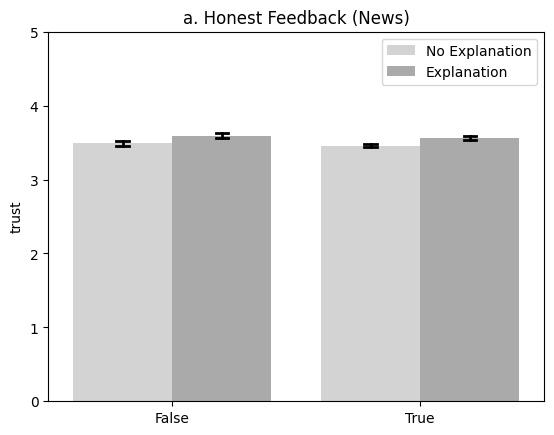

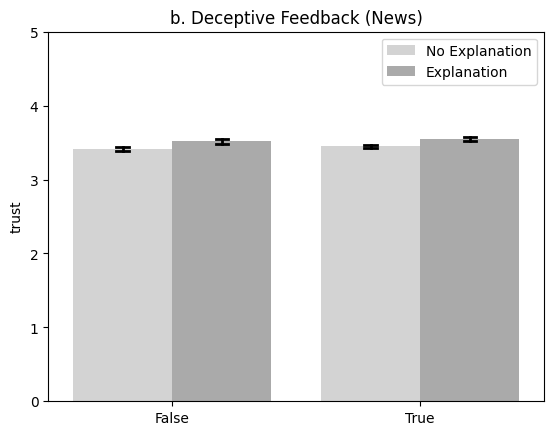

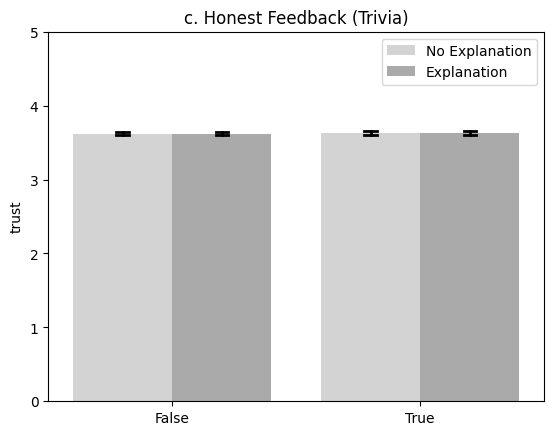

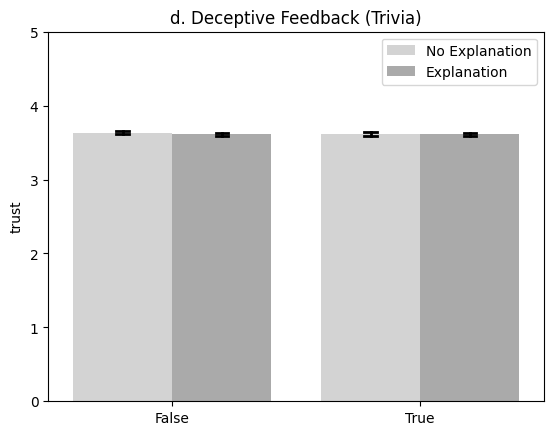

knowledge


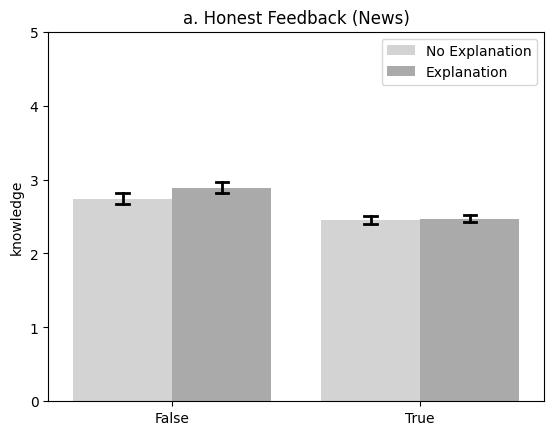

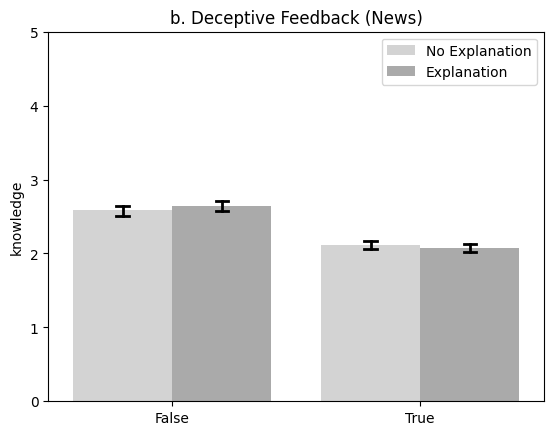

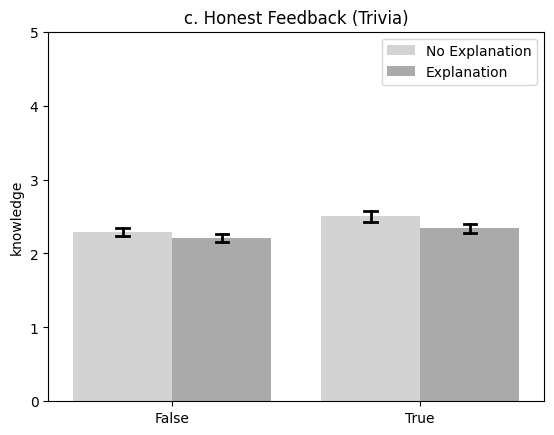

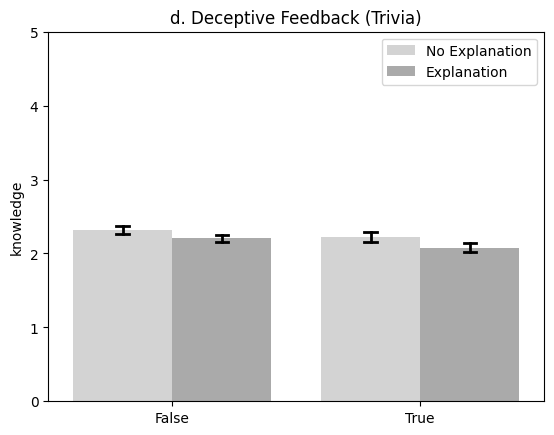

In [58]:
for factor in ['trust', 'knowledge']:
  print(factor)
  def plotter(data,name, x, palette):
      fig = plt.figure()
      ax = fig.add_subplot(1,1,1)

      data['text_explanation'] = data['text_explanation'].map({'No Explanation':'No Explanation', 'GPT Explanation' : 'Explanation'})
      data['true_statement'] = data['true_statement'].map({0:'False', 1 : 'True'})
      ax = sns.barplot(x="true_statement", y=factor,hue='text_explanation',
                      order=['False', 'True'],                    
                      hue_order=['No Explanation', 'Explanation'],
                      data=data, 
                      alpha=.99,
                      errcolor="black", errwidth=2, capsize=.05,
                      palette=palette)
      
      #ax.set_ylabel("Normalized Change in Truth Rating")
      ax.set_xlabel("")
      ax.legend()
      ax.set_ylim(0,5)
      ax.set_title("{}".format(name))
      fig.savefig(f"f1_{factor}_{name}.png",dpi=600, bbox_inches="tight")
      plt.show()


  blue_palette = sns.set_palette(sns.color_palette([lightgrey, darkgrey]))
  plotter(df[(df.trivia==0) & (df.deceptive_feedback==0)],"a. Honest Feedback (News)","text_explanation", blue_palette)
  red_palette = sns.set_palette(sns.color_palette([lightgrey, darkgrey]))
  plotter(df[(df.trivia==0) & (df.deceptive_feedback==1)],"b. Deceptive Feedback (News)","text_explanation", red_palette)
  blue_palette = sns.set_palette(sns.color_palette([lightgrey, darkgrey]))
  plotter(df[(df.trivia==1) & (df.deceptive_feedback==0)],"c. Honest Feedback (Trivia)","text_explanation", blue_palette)
  red_palette = sns.set_palette(sns.color_palette([lightgrey, darkgrey]))
  plotter(df[(df.trivia==1) & (df.deceptive_feedback==1)],"d. Deceptive Feedback (Trivia)","text_explanation", red_palette)

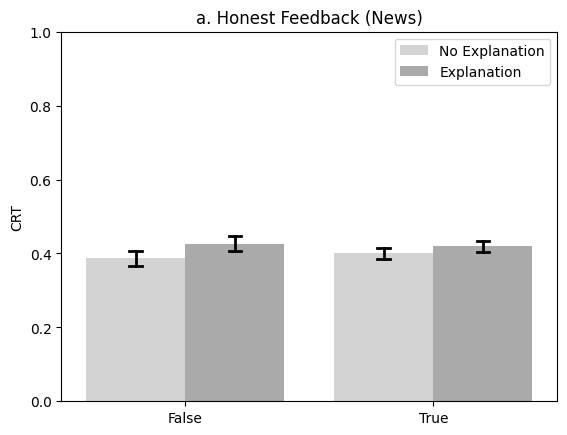

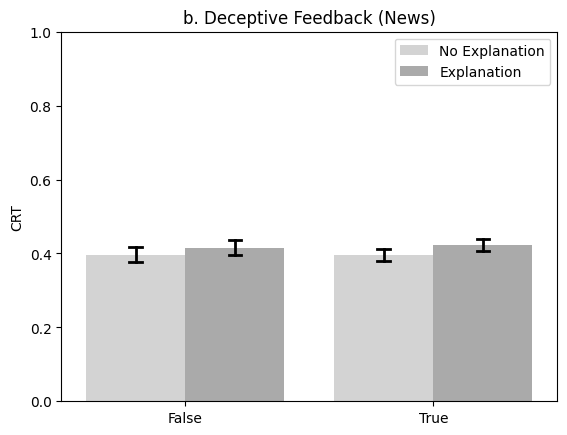

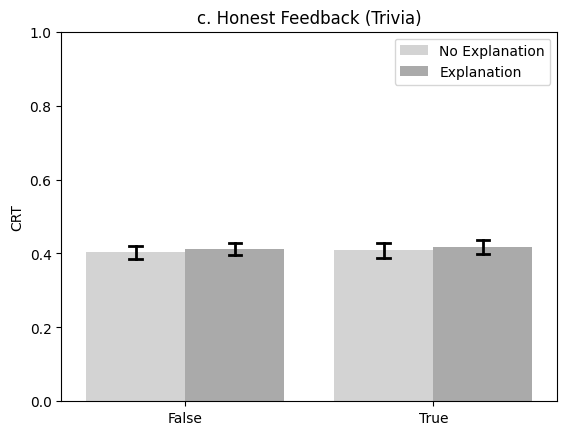

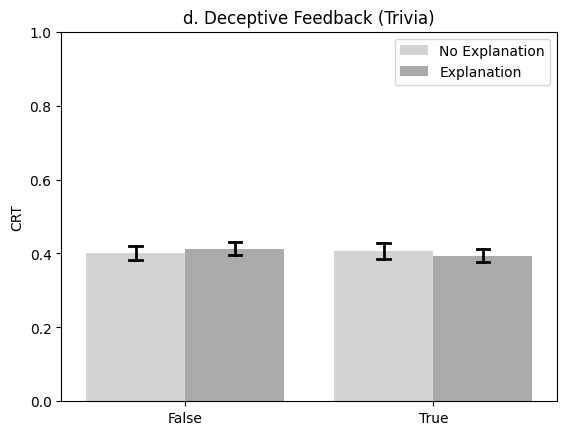

In [60]:
def plotter(data,name, x, palette):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)

    data['text_explanation'] = data['text_explanation'].map({'No Explanation':'No Explanation', 'GPT Explanation' : 'Explanation'})
    data['true_statement'] = data['true_statement'].map({0:'False', 1 : 'True'})
    ax = sns.barplot(x="true_statement", y='CRT',hue='text_explanation',
                    order=['False', 'True'],                    
                    hue_order=['No Explanation', 'Explanation'],
                    data=data, 
                    alpha=.99,
                    errcolor="black", errwidth=2, capsize=.05,
                    palette=palette)
    
    #ax.set_ylabel("Normalized Change in Truth Rating")
    ax.set_xlabel("")
    ax.legend()
    ax.set_ylim(0,1)
    ax.set_title("{}".format(name))
    fig.savefig(f"f1_CRT_{name}.png",dpi=600, bbox_inches="tight")
    plt.show()


blue_palette = sns.set_palette(sns.color_palette([lightgrey, darkgrey]))
plotter(df[(df.trivia==0) & (df.deceptive_feedback==0)],"a. Honest Feedback (News)","text_explanation", blue_palette)
red_palette = sns.set_palette(sns.color_palette([lightgrey, darkgrey]))
plotter(df[(df.trivia==0) & (df.deceptive_feedback==1)],"b. Deceptive Feedback (News)","text_explanation", red_palette)
blue_palette = sns.set_palette(sns.color_palette([lightgrey, darkgrey]))
plotter(df[(df.trivia==1) & (df.deceptive_feedback==0)],"c. Honest Feedback (Trivia)","text_explanation", blue_palette)
red_palette = sns.set_palette(sns.color_palette([lightgrey, darkgrey]))
plotter(df[(df.trivia==1) & (df.deceptive_feedback==1)],"d. Deceptive Feedback (Trivia)","text_explanation", red_palette)